In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import uuid
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
import random
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

2025-09-21 15:56:08.886494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758470169.265804      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758470169.369713      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Dataset split counts
CELEB_DF_COUNTS = {
    'train': {'real': 1130, 'fake': 8022},
    'val': {'real': 100, 'fake': 900},
    'test': {'real': 178, 'fake': 340}
}

FFPP_COUNTS = {
    'train': {'real': 2930, 'fake': 2946},
    'val': {'real': 200, 'fake': 200},
    'test': {'real': 100, 'fake': 100}
}

In [4]:
class DeepfakeDetector:
    def __init__(self, input_shape=(299, 299, 3)):
        self.input_shape = input_shape
        self.models = {}
        self.feature_extractors = {}
        self.scaler = StandardScaler()
        self.knn_classifier = KNeighborsClassifier(n_neighbors=5)
        self.training_histories = {}  # For storing loss curves
        
    def create_data_generator(self, file_paths, labels, batch_size=32, shuffle=True):
        """Create a data generator for training/validation"""
        def generator():
            indices = list(range(len(file_paths)))
            if shuffle:
                np.random.shuffle(indices)
                
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_images = []
                batch_labels = []
                
                for idx in batch_indices:
                    try:
                        # Load and preprocess image
                        img_path = file_paths[idx]
                        image = tf.keras.preprocessing.image.load_img(
                            img_path, target_size=self.input_shape[:2]
                        )
                        image = tf.keras.preprocessing.image.img_to_array(image)
                        image = tf.keras.applications.imagenet_utils.preprocess_input(image)
                        
                        batch_images.append(image)
                        batch_labels.append(labels[idx])
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue
                
                if batch_images:
                    yield np.array(batch_images), np.array(batch_labels)
        
        return generator

    def create_fine_tuned_model(self, model_name, num_classes=2):
        """Create and fine-tune pre-trained models"""
        if model_name == 'DenseNet121':
            base_model = tf.keras.applications.DenseNet121(
                include_top=False,
                weights='imagenet',
                input_shape=self.input_shape,
                pooling='avg'
            )
        elif model_name == 'EfficientNetB0':
            base_model = tf.keras.applications.EfficientNetB0(
                include_top=False,
                weights='imagenet',
                input_shape=self.input_shape,
                pooling='avg'
            )
        elif model_name == 'Xception':
            base_model = tf.keras.applications.Xception(
                include_top=False,
                weights='imagenet',
                input_shape=self.input_shape,
                pooling='avg'
            )
        
        base_model.trainable = True
        
        # Add classification head
        inputs = base_model.input
        x = base_model.output
        x = tf.keras.layers.Dense(512, activation='relu', name=f'{model_name}_dense_512')(x)
        x = tf.keras.layers.Dropout(0.5, name=f'{model_name}_dropout')(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name=f'{model_name}_output')(x)
        
        model = tf.keras.Model(inputs, outputs, name=f'{model_name}_finetuned')
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        
        return model

    def create_feature_extractor(self, model_name):
        """Create feature extractor from fine-tuned model"""
        fine_tuned_model = self.models[model_name]

        # print(fine_tuned_model.layers)
        # Extract from the layer before the final classification layers
        feature_layer = fine_tuned_model.layers[-4].output  # GAP layer
            
        feature_extractor = tf.keras.Model(
            inputs=fine_tuned_model.input,
            outputs=feature_layer,
            name=f'{model_name}_feature_extractor'
        )
        
        return feature_extractor

    def fine_tune_models(self, train_generator, val_generator, steps_per_epoch, val_steps, epochs=100):
        """Fine-tune all three models"""
        model_names = ['DenseNet121', 'EfficientNetB0', 'Xception']
        
        for model_name in model_names:
            print(f"\nFine-tuning {model_name}...")
            
            model = self.create_fine_tuned_model(model_name)
            
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=10,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=5,
                    min_lr=1e-7
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=f'/kaggle/working/{model_name}_best.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    save_weights_only=False
                )
            ]
            

            history = model.fit(
                train_generator(),
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=val_generator(),
                validation_steps=val_steps,
                callbacks=callbacks,
                verbose=1
            )
            
            # Load best weights
            model.load_weights(f'/kaggle/working/{model_name}_best.h5')
            
            self.models[model_name] = model
            
            self.feature_extractors[model_name] = self.create_feature_extractor(model_name)
            
            # loss curve for current model
            plt.figure(figsize=(10, 6))
            
            # Plot training and validation loss
            epochs_range = range(1, len(history.history['loss']) + 1)
            plt.plot(epochs_range, history.history['loss'], 'b-', label='Training', linewidth=2)
            plt.plot(epochs_range, history.history['val_loss'], 'orange', label='Validation', linewidth=2)
            
            # Customizing
            plt.title(f'{model_name} - Training and Validation Loss', fontsize=16, fontweight='bold')
            plt.xlabel('Epochs', fontsize=12)
            plt.ylabel('Loss', fontsize=12)
            plt.legend(fontsize=11)
            plt.grid(True, alpha=0.3)
            plt.xlim(0, len(history.history['loss']))
            plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)
            
            # Saving individual plot
            plt.tight_layout()
            plt.savefig(f'/kaggle/working/{model_name}_loss_curve.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close() # free memory
            
            print(f"Loss curve saved to '/kaggle/working/{model_name}_loss_curve.png'")

    def extract_features(self, file_paths, batch_size=32):
        """Extract features from all three models"""
        model_names = ['DenseNet121', 'EfficientNetB0', 'Xception']
        all_features = {name: [] for name in model_names}
        
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i+batch_size]
            batch_images = []
            
            for img_path in batch_paths:
                try:
                    image = tf.keras.preprocessing.image.load_img(
                        img_path, target_size=self.input_shape[:2]
                    )
                    image = tf.keras.preprocessing.image.img_to_array(image)
                    image = tf.keras.applications.imagenet_utils.preprocess_input(image)
                    batch_images.append(image)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    # Add dummy image if loading fails
                    batch_images.append(np.zeros(self.input_shape))
            
            if batch_images:
                batch_images = np.array(batch_images)
                
                # Extract features from each model
                for model_name in model_names:
                    features = self.feature_extractors[model_name].predict(
                        batch_images, verbose=0
                    )
                    all_features[model_name].extend(features)
        
        # Convert to numpy arrays and stack
        densenet_features = np.array(all_features['DenseNet121'])
        efficientnet_features = np.array(all_features['EfficientNetB0'])
        xception_features = np.array(all_features['Xception'])
        
        stacked_features = np.concatenate([
            densenet_features,
            efficientnet_features,
            xception_features
        ], axis=1)
        
        return stacked_features

    def relief_f_score(self, X, y, k=10):
        """ReliefF feature selection algorithm"""
        n_samples, n_features = X.shape
        feature_scores = np.zeros(n_features)
        
        for i in range(n_samples):
            # Find k nearest neighbors
            distances = np.sum((X - X[i]) ** 2, axis=1)
            nearest_indices = np.argsort(distances)[1:k+1]  # Exclude self
            
            # Separate hits (same class) and misses (different class)
            hits = [idx for idx in nearest_indices if y[idx] == y[i]]
            misses = [idx for idx in nearest_indices if y[idx] != y[i]]
            
            # Update feature scores
            for j in range(n_features):
                if hits:
                    hit_diff = np.mean([abs(X[i, j] - X[idx, j]) for idx in hits])
                    feature_scores[j] -= hit_diff
                
                if misses:
                    miss_diff = np.mean([abs(X[i, j] - X[idx, j]) for idx in misses])
                    feature_scores[j] += miss_diff
        
        return (feature_scores - np.min(feature_scores)) / (np.max(feature_scores) - np.min(feature_scores))

    def mrmr_score(self, X, y, selected_features=None):
        """Minimum Redundancy Maximum Relevance score"""
        if selected_features is None:
            selected_features = []
        
        mi_scores = mutual_info_classif(X, y)
        
        if not selected_features:
            return mi_scores
        
        n_features = X.shape[1]
        mrmr_scores = np.zeros(n_features)
        
        for i in range(n_features):
            if i in selected_features:
                mrmr_scores[i] = -np.inf
                continue
                
            # Relevance (MI with target)
            relevance = mi_scores[i]
            
            # Redundancy (average MI with selected features)
            if selected_features:
                redundancy = np.mean([
                    mutual_info_classif(X[:, [i, j]], y)[0] 
                    for j in selected_features
                ])
            else:
                redundancy = 0
            
            mrmr_scores[i] = relevance - redundancy
        
        return mrmr_scores

    def feature_selection(self, X_train, y_train, X_val, y_val, tau=0.3, alpha=0.1, beta=0.1, max_iterations=250):
        """Combined feature selection with ReliefF, MI, mRMR and inclusion-exclusion"""
        print("Starting feature selection...")
        
        # Step 1: Calculate individual scores
        relief_scores = self.relief_f_score(X_train, y_train)
        mi_scores = mutual_info_classif(X_train, y_train)
        mrmr_scores = self.mrmr_score(X_train, y_train)
        
        # Normalize scores
        relief_scores = (relief_scores - np.min(relief_scores)) / (np.max(relief_scores) - np.min(relief_scores))
        mi_scores = (mi_scores - np.min(mi_scores)) / (np.max(mi_scores) - np.min(mi_scores))
        mrmr_scores = (mrmr_scores - np.min(mrmr_scores)) / (np.max(mrmr_scores) - np.min(mrmr_scores))
        
        # Step 2: Combine scores
        combined_scores = (relief_scores + mi_scores + mrmr_scores) / 3
        
        # Step 3: Initial feature selection (top tau% features)
        n_features = len(combined_scores)
        n_initial = int(tau * n_features)
        initial_indices = np.argsort(combined_scores)[-n_initial:]
        
        # Step 4: Inclusion-exclusion optimization
        best_features = initial_indices.copy()
        best_fitness = self.calculate_fitness(X_val, y_val, best_features)
        
        for iteration in range(max_iterations):
            # Create new candidate solution
            current_features = best_features.copy()
            
            # Exclusion: randomly remove some features
            n_exclude = max(1, int(alpha * len(current_features)))
            if len(current_features) > n_exclude:
                exclude_indices = np.random.choice(
                    len(current_features), n_exclude, replace=False
                )
                current_features = np.delete(current_features, exclude_indices)
            
            # Inclusion: add some features from remaining
            remaining_features = np.setdiff1d(np.arange(n_features), current_features)
            if len(remaining_features) > 0:
                n_include = min(int(beta * n_features), len(remaining_features))
                # Select top features from remaining based on combined scores
                remaining_scores = combined_scores[remaining_features]
                include_indices = remaining_features[np.argsort(remaining_scores)[-n_include:]]
                current_features = np.concatenate([current_features, include_indices])
            
            current_fitness = self.calculate_fitness(X_val, y_val, current_features)
            
            # Update best solution if improved
            if current_fitness > best_fitness:
                best_features = current_features.copy()
                best_fitness = current_fitness
                print(f"Iteration {iteration}: New best fitness = {best_fitness:.4f}, Features = {len(best_features)}")
        
        print(f"Feature selection completed. Selected {len(best_features)} features out of {n_features}")
        return best_features

    def calculate_fitness(self, X_val, y_val, feature_indices, weight=0.9):
        """Calculate fitness function for feature selection"""
        if len(feature_indices) == 0:
            return 0
        
        X_selected = X_val[:, feature_indices]
        
        temp_knn = KNeighborsClassifier(n_neighbors=5)
        temp_knn.fit(self.scaler.fit_transform(X_selected), y_val)
        accuracy = temp_knn.score(self.scaler.transform(X_selected), y_val)
        
        # Fitness combines accuracy and feature reduction
        feature_ratio = len(feature_indices) / X_val.shape[1]
        fitness = weight * accuracy + (1 - weight) * (1 - feature_ratio)
        
        return fitness

    def train_knn_classifier(self, X_train, y_train, selected_features):
        """Train KNN classifier on selected features"""
        X_selected = X_train[:, selected_features]
        X_scaled = self.scaler.fit_transform(X_selected)
        self.knn_classifier.fit(X_scaled, y_train)

    def predict(self, X_test, selected_features):
        """Make predictions using trained KNN classifier"""
        X_selected = X_test[:, selected_features]
        X_scaled = self.scaler.transform(X_selected)
        predictions = self.knn_classifier.predict(X_scaled)
        probabilities = self.knn_classifier.predict_proba(X_scaled)
        return predictions, probabilities

In [5]:
def prepare_dataset(dataset_name, base_path):
    """Prepare dataset paths and labels"""
    if dataset_name == 'FFPP':
        fake_paths = sorted(glob.glob(os.path.join(base_path, "fake", "Deepfakes", "*", "*.png")))
        real_paths = sorted(glob.glob(os.path.join(base_path, "real", "*", "*.png")))
        
        np.random.shuffle(fake_paths)
        np.random.shuffle(real_paths)
        
        train_paths = (
            real_paths[:FFPP_COUNTS['train']['real']] +
            fake_paths[:FFPP_COUNTS['train']['fake']]
        )
        val_paths = (
            real_paths[FFPP_COUNTS['train']['real']:FFPP_COUNTS['train']['real']+FFPP_COUNTS['val']['real']] +
            fake_paths[FFPP_COUNTS['train']['fake']:FFPP_COUNTS['train']['fake']+FFPP_COUNTS['val']['fake']]
        )
        test_paths = (
            real_paths[-FFPP_COUNTS['test']['real']:] +
            fake_paths[-FFPP_COUNTS['test']['fake']:]
        )
        
        train_labels = [0] * FFPP_COUNTS['train']['real'] + [1] * FFPP_COUNTS['train']['fake']
        val_labels = [0] * FFPP_COUNTS['val']['real'] + [1] * FFPP_COUNTS['val']['fake']
        test_labels = [0] * FFPP_COUNTS['test']['real'] + [1] * FFPP_COUNTS['test']['fake']
        
    elif dataset_name == 'CelebDF':
        train_real = sorted(glob.glob(os.path.join(base_path, "train", "real", "*.jpg")))
        train_fake = sorted(glob.glob(os.path.join(base_path, "train", "fake", "*.jpg")))
        val_real = sorted(glob.glob(os.path.join(base_path, "val", "real", "*.jpg")))
        val_fake = sorted(glob.glob(os.path.join(base_path, "val", "fake", "*.jpg")))
        test_real = sorted(glob.glob(os.path.join(base_path, "test", "real", "*.jpg")))
        test_fake = sorted(glob.glob(os.path.join(base_path, "test", "fake", "*.jpg")))
        
        train_paths = train_real + train_fake
        val_paths = val_real + val_fake
        test_paths = test_real + test_fake
        
        train_labels = [0] * len(train_real) + [1] * len(train_fake)
        val_labels = [0] * len(val_real) + [1] * len(val_fake)
        test_labels = [0] * len(test_real) + [1] * len(test_fake)
    
    train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
    val_paths, val_labels = shuffle(val_paths, val_labels, random_state=42)
    test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)
    
    return {
        'train': (train_paths, train_labels),
        'val': (val_paths, val_labels),
        'test': (test_paths, test_labels)
    }

def run_experiment(train_dataset, test_dataset, train_path, test_path):
    """Run complete experiment (intra-dataset or inter-dataset)"""
    print(f"\n{'='*50}")
    print(f"Running experiment: {train_dataset} -> {test_dataset}")
    print(f"{'='*50}")
    
    detector = DeepfakeDetector()
    
    train_data = prepare_dataset(train_dataset, train_path)
    test_data = prepare_dataset(test_dataset, test_path)
    
    # Convert labels to categorical for fine-tuning
    train_labels_cat = tf.keras.utils.to_categorical(train_data['train'][1], 2)
    val_labels_cat = tf.keras.utils.to_categorical(train_data['val'][1], 2)
    
    train_gen = detector.create_data_generator(
        train_data['train'][0], train_labels_cat, batch_size=32
    )
    val_gen = detector.create_data_generator(
        train_data['val'][0], val_labels_cat, batch_size=32
    )
    
    steps_per_epoch = len(train_data['train'][0]) // 32
    val_steps = len(train_data['val'][0]) // 32
    
    detector.fine_tune_models(train_gen, val_gen, steps_per_epoch, val_steps, epochs=100)
    
    print("\nExtracting features...")
    train_features = detector.extract_features(train_data['train'][0])
    val_features = detector.extract_features(train_data['val'][0])
    test_features = detector.extract_features(test_data['test'][0])
    
    print(f"Feature dimensions: {train_features.shape[1]}")
    
    # Feature selection
    selected_features = detector.feature_selection(
        train_features, train_data['train'][1],
        val_features, train_data['val'][1]
    )
    
    print(f"\nTraining KNN classifier with {len(selected_features)} selected features...")
    detector.train_knn_classifier(train_features, train_data['train'][1], selected_features)
    
    # Evaluate on test set
    test_predictions, test_probabilities = detector.predict(test_features, selected_features)
    
    test_accuracy = accuracy_score(test_data['test'][1], test_predictions)
    test_auc = roc_auc_score(test_data['test'][1], test_probabilities[:, 1])
    
    print(f"\nResults for {train_dataset} -> {test_dataset}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Original features: {train_features.shape[1]}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Feature reduction: {(1 - len(selected_features)/train_features.shape[1])*100:.2f}%")
    
    # Confusion matrix
    cm = confusion_matrix(test_data['test'][1], test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {train_dataset} -> {test_dataset}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'/kaggle/working/confusion_matrix_{train_dataset}-{test_dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': test_accuracy,
        'auc': test_auc,
        'selected_features': len(selected_features),
        'original_features': train_features.shape[1]
    }



Running experiment: FFPP -> FFPP

Fine-tuning DenseNet121...


I0000 00:00:1758470227.207511      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758470227.208222      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


I0000 00:00:1758470328.878868      63 service.cc:148] XLA service 0x7d93f0004db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758470328.880594      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758470328.880616      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758470337.523318      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758470430.478052      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 317s 650ms/step - accuracy: 0.7697 - auc: 0.8508 - loss: 0.4389 - val_accuracy: 0.9062 - val_auc: 0.9676 - val_loss: 0.2864 - learning_rate: 1.0000e-04
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 96s 11ms/step - accuracy: 0.8000 - auc: 0.8362 - loss: 0.9173 - val_accuracy: 0.9219 - val_auc: 0.9910 - val_loss: 0.1218 - learning_rate: 1.0000e-04
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9843 - auc: 0.9993 - loss: 0.0594 - val_accuracy: 0.9688 - val_auc: 0.9971 - val_loss: 0.0632 - learning_rate: 1.0000e-04
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9530 - auc: 0.9963 - loss: 0.0852 - val_accuracy: 0.9844 - val_auc: 0.9980 - val_loss: 0.0744 - learning_rate: 1.0000e-04
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9843 - auc: 0.9998 - loss: 0.0391 - val_accuracy: 0.9531 - val_auc: 0.9966 - val_loss: 0.0880 - learning_rate: 1.0000e-04
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accu

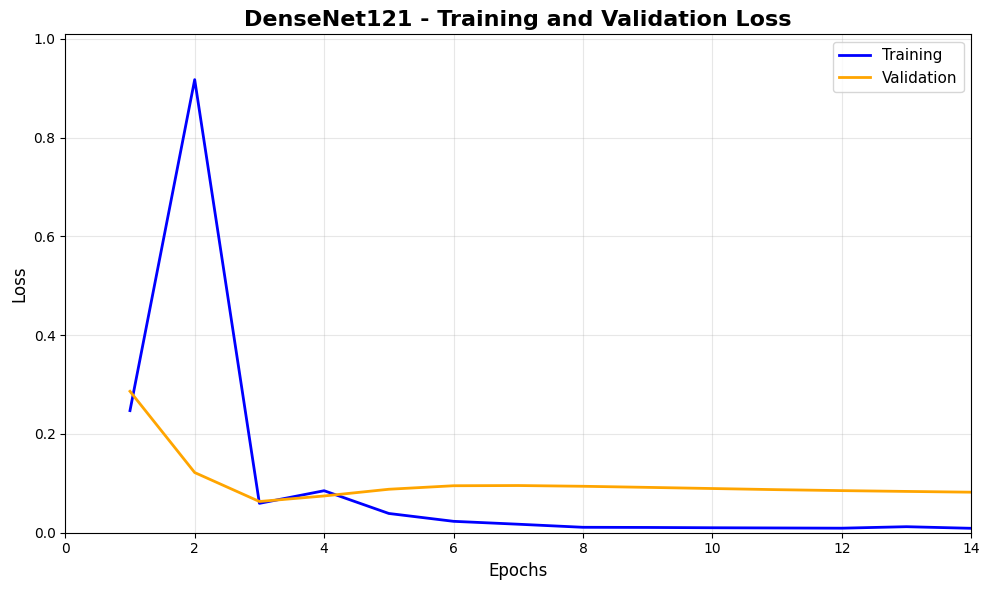

Loss curve saved to '/kaggle/working/DenseNet121_loss_curve.png'

Fine-tuning EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


E0000 00:00:1758470737.012261      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470737.214732      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470746.215257      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470746.367781      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470746.859316      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

183/183 ━━━━━━━━━━━━━━━━━━━━ 154s 302ms/step - accuracy: 0.7369 - auc_1: 0.8104 - loss: 0.4760 - val_accuracy: 0.8750 - val_auc_1: 0.9421 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 2/100


E0000 00:00:1758470831.343953      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470831.522851      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470838.213143      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470838.356514      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758470838.832521      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9000 - auc_1: 0.9700 - loss: 0.2394 - val_accuracy: 0.8594 - val_auc_1: 0.9619 - val_loss: 0.2655 - learning_rate: 1.0000e-04
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8907 - auc_1: 0.9761 - loss: 0.2246 - val_accuracy: 0.8594 - val_auc_1: 0.9644 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9221 - auc_1: 0.9793 - loss: 0.1845 - val_accuracy: 0.8750 - val_auc_1: 0.9552 - val_loss: 0.2835 - learning_rate: 1.0000e-04
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9845 - auc_1: 0.9964 - loss: 0.0788 - val_accuracy: 0.8750 - val_auc_1: 0.9458 - val_loss: 0.3347 - learning_rate: 1.0000e-04
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9845 - auc_1: 0.9993 - loss: 0.0523 - val_accuracy: 0.8438 - val_auc_1: 0.9221 - val_loss: 0.4126 - learning_rate: 1.0000e-04
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

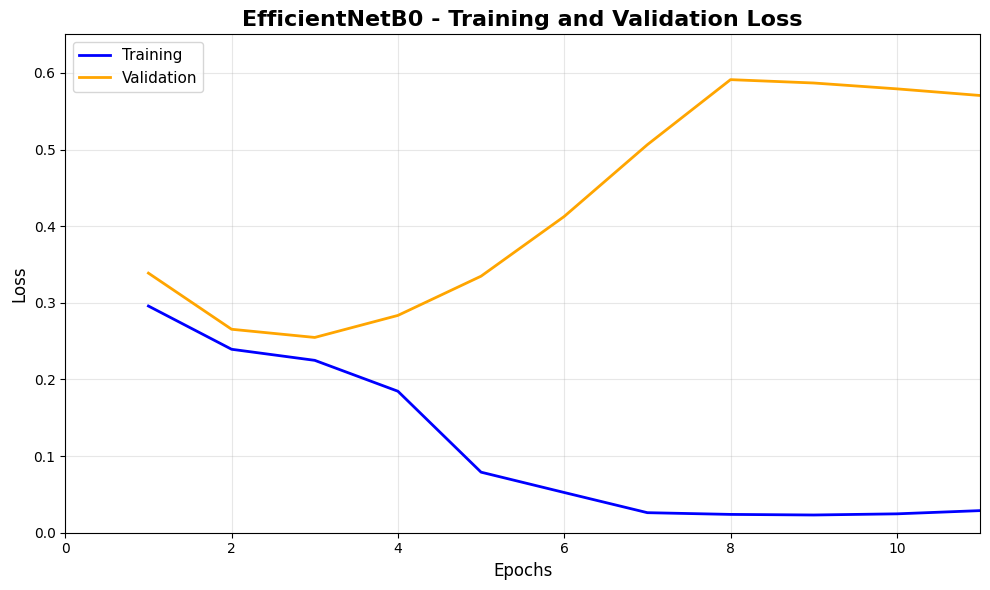

Loss curve saved to '/kaggle/working/EfficientNetB0_loss_curve.png'

Fine-tuning Xception...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


2025-09-21 16:08:37.821741: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-21 16:08:38.083603: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.261971069s
Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone

183/183 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.8358 - auc_2: 0.9059 - loss: 0.3340 - val_accuracy: 0.8359 - val_auc_2: 0.9248 - val_loss: 0.5055 - learning_rate: 1.0000e-04
Epoch 2/100


E0000 00:00:1758471169.925255      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471170.162170      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471171.938832      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471172.145552      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471173.546840      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.0403 - val_accuracy: 0.7812 - val_auc_2: 0.8782 - val_loss: 0.6550 - learning_rate: 1.0000e-04
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9375 - auc_2: 0.9912 - loss: 0.1582 - val_accuracy: 0.7656 - val_auc_2: 0.8604 - val_loss: 0.7058 - learning_rate: 1.0000e-04
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9689 - auc_2: 0.9971 - loss: 0.0741 - val_accuracy: 0.7812 - val_auc_2: 0.8645 - val_loss: 0.6448 - learning_rate: 1.0000e-04
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.0280 - val_accuracy: 0.7500 - val_auc_2: 0.8882 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.0163 - val_accuracy: 0.7969 - val_auc_2: 0.9144 - val_loss: 0.4581 - learning_rate: 1.0000e-04
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 15

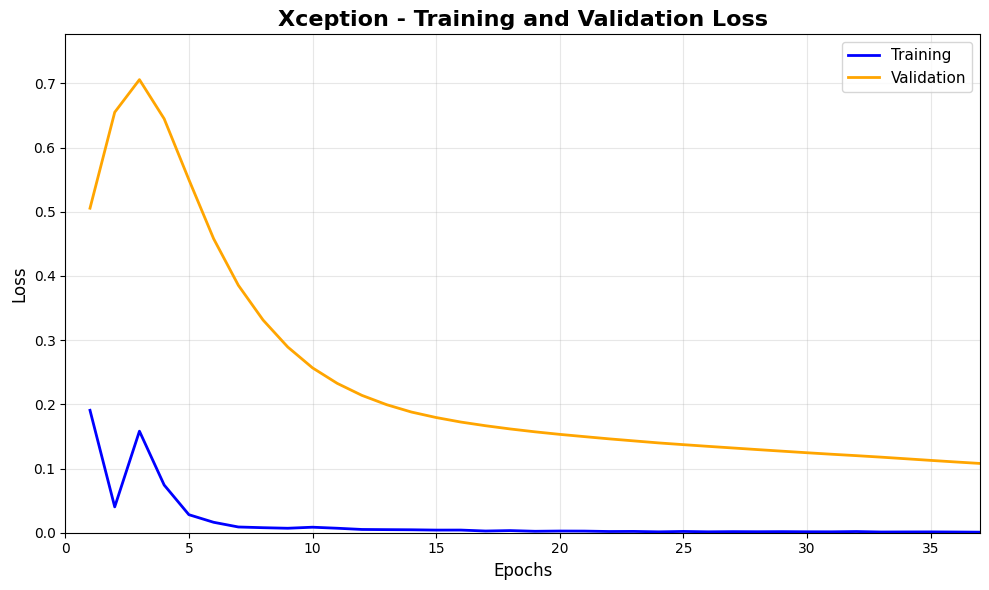

Loss curve saved to '/kaggle/working/Xception_loss_curve.png'

Extracting features...


E0000 00:00:1758471586.839865      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471587.011829      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471620.385930      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471620.537878      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758471620.687776      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Feature dimensions: 4352
Starting feature selection...
Feature selection completed. Selected 1305 features out of 4352

Training KNN classifier with 1305 selected features...

Results for FFPP -> FFPP:
Test Accuracy: 0.9950
Test AUC: 0.9997
Original features: 4352
Selected features: 1305
Feature reduction: 70.01%


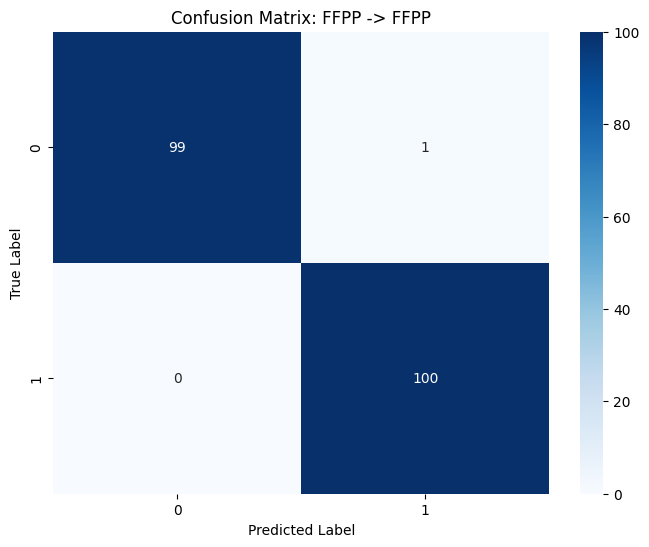




{'accuracy': 0.995,
 'auc': 0.9996999999999999,
 'original_features': 4352,
 'selected_features': 1305}


In [6]:
from pprint import pprint as pp

if __name__ == "__main__":
    ffpp_path = "/kaggle/input/faceforencispp-extracted-frames/"
    try:
        result = run_experiment('FFPP', 'FFPP', ffpp_path, ffpp_path)

        print('\n\n')
        pp(result)

    except Exception as e:
        print(f"Error in experiment: {e}")
        import traceback
        traceback.print_exc()